<a href="https://colab.research.google.com/github/sjoon0305/Simulation/blob/main/3_simple ODE system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(1, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 2)
        self.activation = torch.tanh

    def forward(self, x):
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        x = self.activation(self.hidden3(x))
        return self.output(x)

In [3]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [45]:
# ODE 정의
def ode_loss(x, y_pred):
    y1, y2 = y_pred[:, 0:1], y_pred[:, 1:2]
    dy1_dx = torch.autograd.grad(y1, x, torch.ones_like(y1), create_graph=True)[0]
    dy2_dx = torch.autograd.grad(y2, x, torch.ones_like(y2), create_graph=True)[0]
    ode1 = dy1_dx - y2
    ode2 = dy2_dx + y1
    return torch.mean(ode1**2 + ode2**2)

def boundary_loss(y_pred_bc, y1_bc, y2_bc):
    y1_pred, y2_pred = y_pred_bc[:, 0:1], y_pred_bc[:, 1:2]
    return torch.mean((y1_pred - y1_bc)**2 + (y2_pred - y2_bc)**2)

# 해
def solution(x): 
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

# 경계 조건
x_bc_np = np.zeros((500, 1))
y1_bc_np = np.zeros((500, 1))
y2_bc_np = np.ones((500, 1))

x_bc = torch.tensor(x_bc_np, dtype=torch.float32)
y1_bc = torch.tensor(y1_bc_np, dtype=torch.float32)
y2_bc = torch.tensor(y2_bc_np, dtype=torch.float32)

x_train = torch.rand(500, 1) * 10  # 0과 10 사이의 랜덤 값 생성
x_train.requires_grad_(True)

tensor([[4.8954e+00],
        [4.8356e+00],
        [7.5158e+00],
        [3.7632e+00],
        [6.2613e+00],
        [7.0105e+00],
        [5.3053e+00],
        [6.9853e+00],
        [5.0828e+00],
        [4.0325e+00],
        [1.5224e-01],
        [1.8753e+00],
        [7.9485e+00],
        [5.3968e+00],
        [3.5163e+00],
        [8.8228e-01],
        [9.3331e+00],
        [9.8946e+00],
        [7.0561e-01],
        [2.0978e+00],
        [5.4970e+00],
        [6.3953e-01],
        [7.1983e+00],
        [5.6467e+00],
        [6.7550e+00],
        [6.6506e-01],
        [8.4745e+00],
        [5.9868e-01],
        [5.3599e+00],
        [7.2286e+00],
        [3.2526e+00],
        [2.8401e+00],
        [5.5281e+00],
        [3.7828e+00],
        [5.9115e+00],
        [2.7183e-01],
        [9.3250e+00],
        [6.7600e+00],
        [2.1739e+00],
        [7.7327e+00],
        [4.6119e+00],
        [1.4917e+00],
        [8.1983e+00],
        [2.9936e+00],
        [2.1294e-01],
        [2

In [46]:
# 학습
num_epochs = 20000
for i in range(num_epochs):
    optimizer.zero_grad()

    y_pred = net(x_train)
    
    y_pred_bc = net(x_bc)

    loss_ode = ode_loss(x_train, y_pred)
    loss_bc = boundary_loss(y_pred_bc, y1_bc, y2_bc) 
    loss = loss_ode + loss_bc
    
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

Iteration 0: Loss = 0.0200036708265543
Iteration 1000: Loss = 3.6846574857918313e-06
Iteration 2000: Loss = 2.7150745154358447e-06
Iteration 3000: Loss = 2.218547933807713e-06
Iteration 4000: Loss = 1.5338847560997237e-06
Iteration 5000: Loss = 1.3886010492569767e-06
Iteration 6000: Loss = 1.2502107438194798e-06
Iteration 7000: Loss = 1.2048901226080488e-05
Iteration 8000: Loss = 1.9516101019689813e-06
Iteration 9000: Loss = 8.84706878423458e-07
Iteration 10000: Loss = 2.3688558030698914e-06
Iteration 11000: Loss = 1.1697406989696901e-06
Iteration 12000: Loss = 1.7353443126921775e-06
Iteration 13000: Loss = 2.195062734244857e-06
Iteration 14000: Loss = 5.771165888290852e-06
Iteration 15000: Loss = 4.958800673193764e-06
Iteration 16000: Loss = 2.6693423933465965e-06
Iteration 17000: Loss = 3.979060420533642e-05
Iteration 18000: Loss = 2.467752892698627e-05
Iteration 19000: Loss = 4.108065695618279e-06


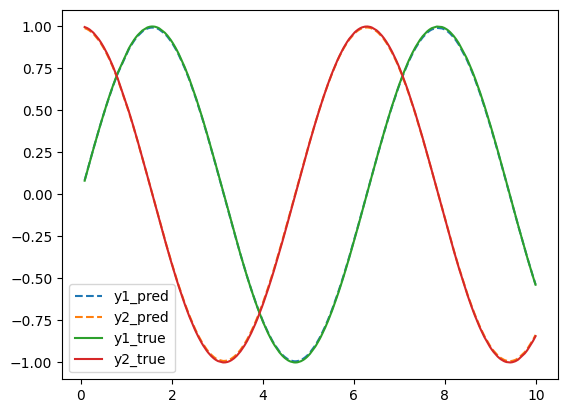

In [47]:
x_test = torch.rand(300, 1) * 10  # 0과 10 사이의 랜덤 값 생성
y_test = net(x_test).detach().numpy()
y_true = solution(x_test.detach().numpy())

# x_test와 그에 대응하는 y_test, y_true를 정렬
sorted_indices = x_test[:, 0].argsort()  # 첫 번째 차원 기준으로 정렬
x_test_sorted = x_test[sorted_indices].detach().numpy()
y_test_sorted = y_test[sorted_indices]
y_true_sorted = y_true[sorted_indices]

# 시각화
plt.plot(x_test_sorted, y_test_sorted[:, 0], label="y1_pred", linestyle="--")
plt.plot(x_test_sorted, y_test_sorted[:, 1], label="y2_pred", linestyle="--")
plt.plot(x_test_sorted, y_true_sorted[:, 0], label="y1_true")
plt.plot(x_test_sorted, y_true_sorted[:, 1], label="y2_true")

plt.legend()
plt.show()